# Preliminaries: Inspect and Set up environment

In [26]:
# Import all libraries required

# Data Processing and EDA
import datetime
import pandas as pd
import numpy as np

# For bioinformatics tasks
from Bio import SeqIO

# For Machine Learning
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# For Evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from seaborn import heatmap
import matplotlib.pyplot as plt

In [27]:
# Environment
# Show all the output for every print not just the last
from IPython.core.interactiveshell import InteractiveShell
# Configuration and settings
InteractiveShell.ast_node_interactivity = "all"
# To check if in Google Colab
from IPython.core.getipython import get_ipython
# To display all the output in a nicer table
from IPython.display import display
# To time the execution of the code
import time

In [28]:
print(datetime.datetime.now())

2024-07-04 23:05:13.117229


In [29]:
!which python

/home/ajvilleg/miniforge3/envs/learn-flu/bin/python


In [30]:
!python --version

Python 3.12.2


In [31]:
!echo $PYTHONPATH

In [32]:
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [33]:
#if 'google.colab' in str(get_ipython()):
    # TODO: if running on Google Colab, install any packages you need to here. For example:
    #!pip install unidecode
    #!pip install category_encoders
    #!pip install scikeras

In [34]:
# Let's minimize randomness
# numpy
np.random.seed(42)

Start the timer

In [35]:
# Start timing the entire process
start_time = time.time()

# 1.0 Data Exploration

## 1.1 Load data

In [36]:
# Parse the FASTA file
records = list(SeqIO.parse("/home/ajvilleg/Netdrive/AI/GISAID/EpiFlu_Training/30-Jun-2024/gisaid_epiflu_sequence_2024-06-30.fasta", "fasta"))


In [37]:
# Extract the details from the description of each record
data = []

# Iterate through records for every pair for NA and HA segments
for record1, record2 in zip(records[::2], records[1::2]):
    description1 = record1.description.split('|')
    description2 = record2.description.split('|')

    # Assume the isolate name is the same for both segments
    isolate_name1 = description1[0].strip()
    isolate_name2 = description2[0].strip()
    if isolate_name1 != isolate_name2:
        print(f"Isolate names do not match: {isolate_name1} vs {isolate_name2}")
        raise ValueError("Isolate names do not match")

    # Assume the isolate ID is the same for both segments
    isolate_id1 = description1[1].strip()
    isolate_id2 = description2[1].strip()
    if isolate_id1 != isolate_id2:
        print(f"Isolate IDs do not match: {isolate_id1} vs {isolate_id2}")
        raise ValueError("Isolate IDs do not match")

    # Assume the flu type is the same for both segments
    flu_type1 = description1[2].strip()
    flu_type2 = description2[2].strip()
    if flu_type1 != flu_type2:
        print(f"Flu types do not match: {flu_type1} vs {flu_type2}")
        raise ValueError("Flu types do not match")

    # Assume the lineage is the same for both segments
    lineage1 = description1[3].strip()
    lineage2 = description2[3].strip()
    if lineage1 != lineage2:
        print(f"Lineages do not match: {lineage1} vs {lineage2}")
        raise ValueError("Lineages do not match")

    # The segment labels are different for NA and HA segments
    segment1 = description1[4].strip()
    segment2 = description2[4].strip()  

    # Assume the collection date is the same for both segments
    collection_date1 = description1[5].strip()
    collection_date2 = description2[5].strip()
    if collection_date1 != collection_date2:
        print(f"Collection dates do not match: {collection_date1} vs {collection_date2}")
        raise ValueError("Collection dates do not match")

    # Assume the clade is the same for both segments. This is important as this will be our label for classification
    clade1 = description1[6].strip()
    clade2 = description2[6].strip()
    if clade1 != clade2:
        print(f"Clades do not match: {clade1} vs {clade2}")
        raise ValueError("Clades do not match")

    # The sequences will be different corresopnding to the NA and HA segments
    sequence1 = str(record1.seq)
    sequence2 = str(record2.seq)
    if segment1 == 'HA':
        sequence_ha = sequence1
        sequence_na = sequence2
    else: # segment2 == 'HA'
        sequence_ha = sequence2
        sequence_na = sequence1
    data.append([isolate_name1, isolate_id1, flu_type1, lineage1, sequence_ha, sequence_na, collection_date1, clade1])

df = pd.DataFrame(data, columns=['Isolate_Name', 'Isolate_ID', 'Flu_Type', 'Lineage', 'HA', 'NA', 'Collection Date', 'Clade'])


In [38]:
# Take a look at the data  
display(df)

,Isolate_Name,Isolate_ID,Flu_Type,Lineage,HA,NA,Collection Date,Clade
0,A/Michigan/136/2018,EPI_ISL_360559,A_/_H1N1,pdm09,ggaaaacaaaagcaacaaaaatgaaggcaatactagtagttctgct...,agtttaaaatgaatccaaaccaaaagataataaccattggttcgat...,2018-01-16,6B.1A
1,A/USA/7C9/2010,EPI_ISL_17760636,A_/_H1N1,pdm09,atgaaggcaatactagtagttctgctatatacatttgcaaccgcaa...,atgaatccaaaccaaaagataataaccattggttcgatctgtatga...,2010-11-01,6B.1
2,A/USA/7C7/2010,EPI_ISL_17760635,A_/_H1N1,pdm09,atgaaggcaatactagtagttctgctatatacatttgcaaccgcaa...,atgaatccaaaccaaaagataataaccattggttcgatctgtatga...,2010-11-01,6B.1
3,A/USA/7K3/1935,EPI_ISL_17760634,A_/_H1N1,pdm09,atgaaggcaatactagtagttctgctatatacatttgcaaccgcaa...,atgaatccaaaccaaaagataataaccattggttcggtctgtatga...,2010-11-01,6B.1
4,A/Michigan/98/2018,EPI_ISL_360571,A_/_H1N1,pdm09,ggaaaacaaaagcaacaaaaatgaaggcaatactagtagttctgct...,agtttaaaatgaatccaaaccaaaagataataaccattggttcgat...,2018-01-08,6B.1A
...,...,...,...,...,...,...,...,...
15414,A/Washington/97/2020,EPI_ISL_2588628,A_/_H1N1,pdm09,ggaaaacaaaagcaacaaaaatgaaggcaatactagtagttatgct...,agtttaaaatgaatccaaaccaaaagataataaccattggttctat...,2020-02-04,6B.1A.5a.2
15415,A/Washington/96/2020,EPI_ISL_2588627,A_/_H1N1,pdm09,ggaaaacaaaagcaacaaaaatgaaggcaatactagtagttatgct...,agtttaaaatgaatccaaaccaaaagataataaccattggttctat...,2020-02-04,6B.1A.5a.2
15416,A/Washington/90/2020,EPI_ISL_2588626,A_/_H1N1,pdm09,ggaaaacaaaagcaacaaaaatgaaggcaatactagtagttctgct...,agtttaaaatgaatccaaaccaaaagataataaccattggctctat...,2020-02-02,6B.1A.5a.1
15417,A/Pennsylvania/164/2020,EPI_ISL_2588633,A_/_H1N1,pdm09,ggaaaacaaaagcaacaaaaatgaaggcaatactagtagttatgct...,agtttaaaatgaatccaaaccaaaagataataaccattggttctat...,2020-02-24,6B.1A.5a.2


## 1.2 EDA

### 1.2.1 Dataframe structure

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15419 entries, 0 to 15418
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Isolate_Name     15419 non-null  object
 1   Isolate_ID       15419 non-null  object
 2   Flu_Type         15419 non-null  object
 3   Lineage          15419 non-null  object
 4   HA               15419 non-null  object
 5   NA               15419 non-null  object
 6   Collection Date  15419 non-null  object
 7   Clade            15419 non-null  object
dtypes: object(8)
memory usage: 963.8+ KB


In [40]:
# Convert all columns to strings except Collection Date
df = df.astype(str)

# Convert "Collection Date" column to date
df["Collection Date"] = pd.to_datetime(df["Collection Date"])

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15419 entries, 0 to 15418
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Isolate_Name     15419 non-null  object        
 1   Isolate_ID       15419 non-null  object        
 2   Flu_Type         15419 non-null  object        
 3   Lineage          15419 non-null  object        
 4   HA               15419 non-null  object        
 5   NA               15419 non-null  object        
 6   Collection Date  15419 non-null  datetime64[ns]
 7   Clade            15419 non-null  object        
dtypes: datetime64[ns](1), object(7)
memory usage: 963.8+ KB


### 1.2.2 Describe

In [41]:
df.describe()

,Collection Date
count,15419
mean,2017-12-03 02:55:00.914456320
min,2009-01-01 00:00:00
25%,2016-03-03 00:00:00
50%,2019-01-23 00:00:00
75%,2020-01-22 00:00:00
max,2023-04-26 00:00:00


### 1.2.4 Duplicated rows

In [42]:
# Check for duplicated rows in training data
print(f'df has {df.duplicated().sum()} duplicate rows')
display(df[df.duplicated()])
# Drop duplicates and check again
df.drop_duplicates(inplace=True)
print(f'df has {df.duplicated().sum()} duplicate rows')

df has 1 duplicate rows


,Isolate_Name,Isolate_ID,Flu_Type,Lineage,HA,NA,Collection Date,Clade
14162,A/Houston/2OS/2009,EPI_ISL_63939,A_/_H1N1,pdm09,aaaagcaacaaaaatgaaggcaatactagtagttctgctatataca...,aaatgaatccaaaccaaaagataataaccattggttcggtctgtat...,2009-05-18,6B.1


df has 0 duplicate rows


### 1.2.5 Missing values / NaN / Empty Strings

In [43]:
# Check for missing values and empty strings
print("Missing values in df:")
print(df.isnull().sum())  # Check for NaN values
print("\nEmpty string values in df:")
for col in df.select_dtypes(include=['object']):  # Iterate over columns with string datatype
    print(f"{col}: {(df[col] == '').sum()}")     # Count empty strings

Missing values in df:
Isolate_Name       0
Isolate_ID         0
Flu_Type           0
Lineage            0
HA                 0
NA                 0
Collection Date    0
Clade              0
dtype: int64

Empty string values in df:
Isolate_Name: 0
Isolate_ID: 0
Flu_Type: 0
Lineage: 0
HA: 0
NA: 0
Clade: 0


In [44]:
# Drop rows with empty strings in 'Clade' from the training data
df.dropna(subset=['Clade'], inplace=True)  # Drop rows with NaN (including empty strings)

In [45]:
# Check for missing values and empty strings
print("Missing values in df:")
print(df.isnull().sum())  # Check for NaN values
print("\nEmpty string values in df:")
for col in df.select_dtypes(include=['object']):  # Iterate over columns with string datatype
    print(f"{col}: {(df[col] == '').sum()}")     # Count empty strings

Missing values in df:
Isolate_Name       0
Isolate_ID         0
Flu_Type           0
Lineage            0
HA                 0
NA                 0
Collection Date    0
Clade              0
dtype: int64

Empty string values in df:
Isolate_Name: 0
Isolate_ID: 0
Flu_Type: 0
Lineage: 0
HA: 0
NA: 0
Clade: 0


### 1.2.7 Class imbalance in Clade column

In [46]:
df['Clade'].value_counts()

Clade
6B.1             4862
6B.1A.5a.2a.1    1914
6B.1A.1          1576
6B.1A.5a.1       1538
6B.1A.5b         1304
6B.1A.5a.2       1152
6B.1A.5a          922
6B.1A             590
6B.1A.7           510
6B.1A.5a.2a       373
6B.1A.6           300
6B.1A.3           206
6B.1A.2            82
6B.2               44
6B.1A.5            39
unassigned          6
Name: count, dtype: int64

In [47]:
# Drop rows with "unassigned" in 'Clade' from the training data
df = df[df['Clade'] != 'unassigned']  # Filter out rows with label "unassigned"

In [48]:
df['Clade'].value_counts()

Clade
6B.1             4862
6B.1A.5a.2a.1    1914
6B.1A.1          1576
6B.1A.5a.1       1538
6B.1A.5b         1304
6B.1A.5a.2       1152
6B.1A.5a          922
6B.1A             590
6B.1A.7           510
6B.1A.5a.2a       373
6B.1A.6           300
6B.1A.3           206
6B.1A.2            82
6B.2               44
6B.1A.5            39
Name: count, dtype: int64

### 1.2.3 Shape

In [49]:
df.shape

(15412, 8)

### 1.2.6 Look at sequence length stats

In [50]:
def get_sequence_length(row, column):
    """Calculates the length of the sequence in the specified column."""
    return len(row[column])

ha_sequence_lengths = df.apply(get_sequence_length, axis=1, column="HA")
na_sequence_lengths = df.apply(get_sequence_length, axis=1, column="NA")
print("Sequence lengths in HA columns:")
ha_sequence_lengths.describe()
print("Sequence lengths in NA columns:")
na_sequence_lengths.describe()


Sequence lengths in HA columns:


count    15412.000000
mean      1741.636452
std         22.450589
min       1410.000000
25%       1734.000000
50%       1752.000000
75%       1752.000000
max       1922.000000
dtype: float64

Sequence lengths in NA columns:


count    15412.000000
mean      1428.921555
std         12.396946
min       1410.000000
25%       1420.000000
50%       1433.000000
75%       1433.000000
max       1701.000000
dtype: float64

# 2.0 Data Preparation

### 2.1 K-mers and k-mer encoding

In [51]:
# Define k-mer length
kmer_length = 12

In [52]:
# Function to extract kmers (can be reused)
def get_kmers(sequence, k):
  """
  Extracts all k-mers (subsequences of length k) from a DNA sequence.
  """
  kmers = []
  for i in range(len(sequence) - k + 1):
    kmer = sequence[i:i+k]
    kmers.append(kmer)
  return kmers

In [53]:
# Create an empty dictionary to store kmers for each sequence (identified by row index)
kmer_dict = {}

In [54]:
# Extract k-mers with length kmer_length from each sequence and store them in the dictionary
for i, row in df.iterrows():
  # Extract kmers from HA sequence (assuming it exists)
  ha_kmers = []
  if "HA" in row:  # Check if "HA" column exists
    sequence = str(row["HA"])
    ha_kmers = get_kmers(sequence, kmer_length)

  # Extract kmers from NA sequence (assuming it exists)
  na_kmers = []
  if "NA" in row:  # Check if "NA" column exists
    sequence = str(row["NA"])
    na_kmers = get_kmers(sequence, kmer_length)

  # Store kmers separately in the dictionary
  kmer_dict[i] = {
      "HA": ha_kmers,
      "NA": na_kmers,
  }

#### 2.1.1 Count-based Encoding using k-mer chunking to optimize memory usage

In [55]:
# Define chunk size (adjust as needed)
chunk_size = 100

Count-based Encoding (K-mer Chunking) 

In [56]:
def process_chunk(chunk_dict):
    """
    Processes a chunk of data from the kmer_dict and returns count-based features,
    keeping HA and NA k-mer counts separate to avoid overlap issues.
    """
    chunk_ha_features, chunk_na_features = [], []

    for kmer_dict_row in chunk_dict.values():
        # Extract HA and NA kmers
        ha_kmers = kmer_dict_row["HA"]
        na_kmers = kmer_dict_row["NA"]

        # Count occurrences of kmers for HA and NA separately
        ha_kmer_counts = Counter(ha_kmers)
        na_kmer_counts = Counter(na_kmers)

        # START Historical code, just to show the tweak below that drastically improved metrics
        # # Combine counts into a single dictionary (adapt based on your needs)
        # kmer_counts = {**ha_kmer_counts, **na_kmer_counts}

        # # Append features (adapt dimensions based on your encoding)
        # chunk_ha_features.append(list(kmer_counts.values()))
        # chunk_na_features.append(list(kmer_counts.values()))
        # END Historical code

        # START New code tweak, keep HA and NA k-mer counts separate and drastically improved metrics
        # Extract counts and append as features (ensure consistent order for all chunks)
        all_kmers = list(set(ha_kmer_counts.keys()) | set(na_kmer_counts.keys()))  # Get unique k-mers

        chunk_ha_features.append([ha_kmer_counts[kmer] if kmer in ha_kmer_counts else 0 for kmer in all_kmers])
        chunk_na_features.append([na_kmer_counts[kmer] if kmer in na_kmer_counts else 0 for kmer in all_kmers])
        # END New code tweak

    return chunk_ha_features, chunk_na_features

In [57]:
# Iterate through kmer_dict in chunks
ha_features = []
na_features = []
for i in range(0, len(kmer_dict), chunk_size):
  # Get a chunk of data
  chunk_dict = dict(list(kmer_dict.items())[i:i + chunk_size])

  # Process features for the chunk
  chunk_ha_features, chunk_na_features = process_chunk(chunk_dict)

  # Append features from the chunk
  ha_features.extend(chunk_ha_features)
  na_features.extend(chunk_na_features)

### 2.3 Define X and y and Train Test Split

In [58]:
X = []

# Assuming ha_features and na_features contain lists
ha_features = [np.array(l) for l in ha_features]  # Convert lists to arrays
na_features = [np.array(l) for l in na_features]  # Convert lists to arrays

# The arrays in ha_features and na_features have different shapes, we need to ensure that the arrays in ha_features and na_features have the same shape before concatenating them.

In [59]:
# Pad shorter arrays in ha_features and na_features with zeros
# Find the maximum number of features across all arrays
max_feature_count = max(arr.shape[0] for arr in ha_features + na_features)

# Pad shorter arrays in ha_features and na_features with zeros
for i in range(len(ha_features)):
  ha_features[i] = np.pad(ha_features[i], (0, max_feature_count - len(ha_features[i])), mode='constant')

for i in range(len(na_features)):
  na_features[i] = np.pad(na_features[i], (0, max_feature_count - len(na_features[i])), mode='constant')

# Now concatenate by sample/instance (axis=1, instead of axis=0 which is stacking on top of each other) the padded arrays (assuming na_features have consistent shapes)
X = np.concatenate((ha_features, na_features), axis=1)

In [60]:
y = []
le = LabelEncoder()

# Fit the LabelEncoder to all unique classes (call only once)
le.fit(df['Clade'])

for index in df.index:
  clade_label = le.transform(np.array([df.loc[index, "Clade"]]))[0]
  y.append(clade_label)

LabelEncoder()

In [61]:
# Train-test split (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  # Set random_state for reproducibility

# 3.0 Modelling

In [62]:
# Train a Logistic Regression model
model = LogisticRegression(multi_class='ovr', solver='lbfgs')
model.fit(X_train, y_train)

LogisticRegression(multi_class='ovr')

# 4.0 Validation

In [63]:
# Make predictions on the testing set
y_pred = model.predict(X_test)

In [64]:
# Accuracy: Proportion of correctly predicted samples
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Precision: Ratio of true positives to all predicted positives
precision = precision_score(y_test, y_pred, average='weighted')  # Weighted average for multi-class
print("Precision:", precision)

# Recall: Ratio of true positives to all actual positives
recall = recall_score(y_test, y_pred, average='weighted')  # Weighted average for multi-class
print("Recall:", recall)

# F1-score: Harmonic mean of precision and recall
f1 = f1_score(y_test, y_pred, average='weighted')  # Weighted average for multi-class
print("F1-score:", f1)

Accuracy: 0.9698345767109958
Precision: 0.9695473220429863
Recall: 0.9698345767109958
F1-score: 0.9686846249379919


### Classification Report

In [65]:
# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))



Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1006
           1       0.94      0.82      0.88       111
           2       0.95      0.98      0.96       314
           3       1.00      0.89      0.94        19
           4       0.85      0.77      0.81        44
           5       1.00      0.88      0.93         8
           6       0.96      0.98      0.97       175
           7       0.98      1.00      0.99       288
           8       0.98      0.97      0.97       211
           9       0.97      0.94      0.96        82
          10       0.99      0.99      0.99       370
          11       0.97      0.97      0.97       284
          12       0.82      0.78      0.80        51
          13       0.95      0.97      0.96       109
          14       1.00      0.27      0.43        11

    accuracy                           0.97      3083
   macro avg       0.96      0.88      0.90      3083
we

### Confusion Matrix


Confusion Matrix:


<Figure size 800x600 with 0 Axes>

<Axes: >

Text(0.5, 36.72222222222221, 'Predicted Clade')

Text(70.72222222222221, 0.5, 'True Clade')

Text(0.5, 1.0, 'Confusion Matrix')

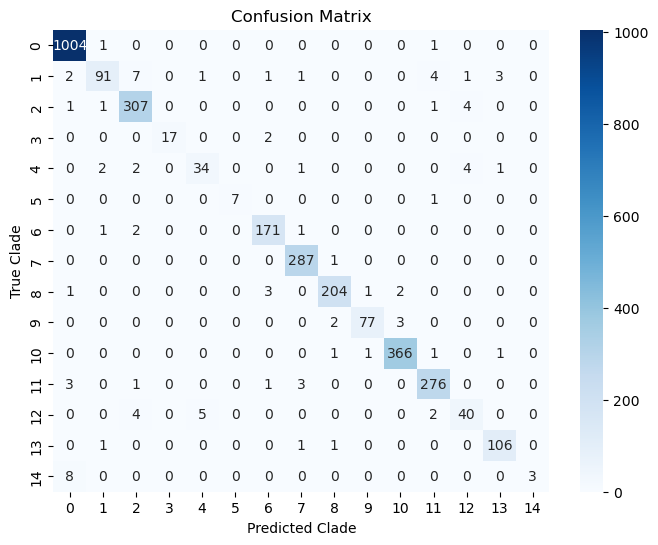

In [66]:
# Confusion Matrix with Seaborn
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)

# Create a new figure for the confusion matrix
plt.figure(figsize=(8, 6))

# Create heatmap using seaborn
heatmap(cm, annot=True, fmt="d", cmap="Blues")  # Customize heatmap with annotations, format, and colormap

# Add labels and title
plt.xlabel("Predicted Clade")
plt.ylabel("True Clade")
plt.title("Confusion Matrix")

# Show the confusion matrix
plt.show()

End the timer

In [67]:
# End timing
end_time = time.time()

In [68]:
# Calculate and print total training and validation runtime
total_time = end_time - start_time
print(f"\nTotal training and validation runtime: {total_time:.2f} seconds")


Total training and validation runtime: 51.63 seconds


# 5.0 Test

## 5.1 Load and Prepare Unseen Test Data

In [69]:
# Parse the FASTA file for the new dataset
test_records = list(SeqIO.parse("/home/ajvilleg/Netdrive/AI/GISAID/EpiFlu_Test/04-Jul-2024_Canada/gisaid_epiflu_sequence_04-Jul-2024_Canada.fasta", "fasta"))

In [70]:
new_data = []

In [71]:

# Iterate through records for every pair for NA and HA segments
for record1, record2 in zip(test_records[::2], test_records[1::2]):
    description1 = record1.description.split('|')
    description2 = record2.description.split('|')

    # Assume the isolate name is the same for both segments
    isolate_name1 = description1[0].strip()
    isolate_name2 = description2[0].strip()
    if isolate_name1 != isolate_name2:
        print(f"Isolate names do not match: {isolate_name1} vs {isolate_name2}")
        raise ValueError("Isolate names do not match")

    # Assume the isolate ID is the same for both segments
    isolate_id1 = description1[1].strip()
    isolate_id2 = description2[1].strip()
    if isolate_id1 != isolate_id2:
        print(f"Isolate IDs do not match: {isolate_id1} vs {isolate_id2}")
        raise ValueError("Isolate IDs do not match")

    # Assume the flu type is the same for both segments
    flu_type1 = description1[2].strip()
    flu_type2 = description2[2].strip()
    if flu_type1 != flu_type2:
        print(f"Flu types do not match: {flu_type1} vs {flu_type2}")
        raise ValueError("Flu types do not match")

    # Assume the lineage is the same for both segments
    lineage1 = description1[3].strip()
    lineage2 = description2[3].strip()
    if lineage1 != lineage2:
        print(f"Lineages do not match: {lineage1} vs {lineage2}")
        raise ValueError("Lineages do not match")

    # The segment labels are different for NA and HA segments
    segment1 = description1[4].strip()
    segment2 = description2[4].strip()  

    # Assume the collection date is the same for both segments
    collection_date1 = description1[5].strip()
    collection_date2 = description2[5].strip()
    if collection_date1 != collection_date2:
        print(f"Collection dates do not match: {collection_date1} vs {collection_date2}")
        raise ValueError("Collection dates do not match")

    # Assume the clade is the same for both segments. This is important as this will be our label for classification
    clade1 = description1[6].strip()
    clade2 = description2[6].strip()
    if clade1 != clade2:
        print(f"Clades do not match: {clade1} vs {clade2}")
        raise ValueError("Clades do not match")

    # The sequences will be different corresopnding to the NA and HA segments
    sequence1 = str(record1.seq)
    sequence2 = str(record2.seq)
    if segment1 == 'HA':
        sequence_ha = sequence1
        sequence_na = sequence2
    else: # segment2 == 'HA'
        sequence_ha = sequence2
        sequence_na = sequence1
    new_data.append([isolate_name1, isolate_id1, flu_type1, lineage1, sequence_ha, sequence_na, collection_date1, clade1])

new_df = pd.DataFrame(new_data, columns=['Isolate_Name', 'Isolate_ID', 'Flu_Type', 'Lineage', 'HA', 'NA', 'Collection Date', 'Clade'])


In [72]:
display(new_df)

,Isolate_Name,Isolate_ID,Flu_Type,Lineage,HA,NA,Collection Date,Clade
0,A/Manitoba740484/2023,EPI_ISL_18784543,A_/_H1N1,pdm09,atgaaggcaatactagtagttatgctgtatacatttacaaccgcaa...,agtttaaaatgaatccaaaccaaaagataataaccattggttctat...,2023-11-23,6B.1A.5a.2a.1
1,A/Manitoba738411/2023,EPI_ISL_18784540,A_/_H1N1,pdm09,atgaaggcaatactagtagttatgctgtatacatttacaaccgcaa...,agtttaaaatgaatccaaaccaaaagataataaccattggttctat...,2023-11-10,6B.1A.5a.2a.1
2,A/Ontario/RV0019/2011,EPI_ISL_86019,A_/_H1N1,pdm09,atgaaggcaatactagtagttctgctatatacatttgcaaccgcaa...,atgaatccaaaccaaaagataataaccattggttcggtctgtatga...,2010-12-29,6B.1
3,A/Manitoba738222/2023,EPI_ISL_18784541,A_/_H1N1,pdm09,atgaaggcaatactagtagttatgctgtatacatttacaaccgcaa...,agtttaaaatgaatccaaaccaaaagataataaccattggttctat...,2023-11-09,6B.1A.5a.2a.1
4,A/Manitoba/RV01257/2023,EPI_ISL_18899238,A_/_H1N1,pdm09,atgaaggcaatactagtagttatgctgtatacatttacaaccgcaa...,agtttaaaatgaatccaaaccaaaagataataaccattggttctat...,2023-11-09,6B.1A.5a.2a.1
...,...,...,...,...,...,...,...,...
1400,A/New_Brunswick/RV01458/2023,EPI_ISL_18786045,A_/_H1N1,pdm09,ggaaaacaaaagcaacaaaaatgaaggcaatactagtagttatgct...,agtttaaaatgaatccaaaccaaaagataataaccattggttctat...,2023-10-28,6B.1A.5a.2a
1401,A/British_Columbia/RV01391/2023,EPI_ISL_18786042,A_/_H1N1,pdm09,ggaaaacaaaagcaacaaaaatgaaggcaatactagtagttatgct...,agtttaaaatgaatccaaaccaaaagataataaccattggttctat...,2023-11-14,6B.1A.5a.2a.1
1402,A/Manitoba/RV00543/2023,EPI_ISL_18022139,A_/_H1N1,pdm09,ggaaaacaaaagcaacaaaaatgaaggcaatactagtagttatgct...,agtttaaaatgaatccaaaccaaaagataataaccattggttctgt...,2023-05-25,6B.1A.5a.2a.1
1403,A/British_Columbia/PHL-226/2022,EPI_ISL_16283403,A_/_H1N1,pdm09,nnnnnacaaaagcaacaaaaatgaaggcaatactagtagttatgct...,nnntttaaaatgaatccaaaccaaaagataataaccattggttctg...,2022-11-06,6B.1A.5a.2a.1


In [73]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1405 entries, 0 to 1404
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Isolate_Name     1405 non-null   object
 1   Isolate_ID       1405 non-null   object
 2   Flu_Type         1405 non-null   object
 3   Lineage          1405 non-null   object
 4   HA               1405 non-null   object
 5   NA               1405 non-null   object
 6   Collection Date  1405 non-null   object
 7   Clade            1405 non-null   object
dtypes: object(8)
memory usage: 87.9+ KB


In [74]:
# Convert all columns to strings except Collection Date
new_df = new_df.astype(str)

# Convert "Collection Date" column to date
new_df["Collection Date"] = pd.to_datetime(new_df["Collection Date"])

new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1405 entries, 0 to 1404
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Isolate_Name     1405 non-null   object        
 1   Isolate_ID       1405 non-null   object        
 2   Flu_Type         1405 non-null   object        
 3   Lineage          1405 non-null   object        
 4   HA               1405 non-null   object        
 5   NA               1405 non-null   object        
 6   Collection Date  1405 non-null   datetime64[ns]
 7   Clade            1405 non-null   object        
dtypes: datetime64[ns](1), object(7)
memory usage: 87.9+ KB


In [75]:
new_df.describe()

,Collection Date
count,1405
mean,2022-04-14 03:54:42.277580032
min,2009-01-01 00:00:00
25%,2023-06-05 00:00:00
50%,2023-11-22 00:00:00
75%,2024-01-06 00:00:00
max,2024-05-26 00:00:00


In [76]:
# Check for duplicated rows in training data
print(f'new_df has {new_df.duplicated().sum()} duplicate rows')
display(new_df[new_df.duplicated()])
# Drop duplicates and check again
new_df.drop_duplicates(inplace=True)
print(f'new_df has {new_df.duplicated().sum()} duplicate rows')

new_df has 0 duplicate rows


,Isolate_Name,Isolate_ID,Flu_Type,Lineage,HA,NA,Collection Date,Clade


new_df has 0 duplicate rows


In [77]:
# Check for missing values and empty strings
print("Missing values in new_df:")
print(new_df.isnull().sum())  # Check for NaN values
print("\nEmpty string values in new_df:")
for col in new_df.select_dtypes(include=['object']):  # Iterate over columns with string datatype
    print(f"{col}: {(new_df[col] == '').sum()}")     # Count empty strings

Missing values in new_df:
Isolate_Name       0
Isolate_ID         0
Flu_Type           0
Lineage            0
HA                 0
NA                 0
Collection Date    0
Clade              0
dtype: int64

Empty string values in new_df:
Isolate_Name: 0
Isolate_ID: 0
Flu_Type: 0
Lineage: 0
HA: 0
NA: 0
Clade: 2


In [78]:
new_df.shape

(1405, 8)

In [79]:
new_ha_sequence_lengths = new_df.apply(get_sequence_length, axis=1, column="HA")
new_na_sequence_lengths = new_df.apply(get_sequence_length, axis=1, column="NA")
print("Sequence lengths in HA columns:")
new_ha_sequence_lengths.describe()
print("Sequence lengths in NA columns:")
new_na_sequence_lengths.describe()

Sequence lengths in HA columns:


count    1405.000000
mean     1740.661210
std        32.310181
min      1410.000000
25%      1701.000000
50%      1752.000000
75%      1754.000000
max      1791.000000
dtype: float64

Sequence lengths in NA columns:


count    1405.000000
mean     1434.008541
std        24.267178
min      1410.000000
25%      1422.000000
50%      1433.000000
75%      1434.000000
max      1779.000000
dtype: float64

In [80]:
new_df['Clade'].value_counts()

Clade
6B.1A.5a.2a.1    683
6B.1A.5a.2a      470
6B.1             137
6B.1A             26
6B.1A.5b          23
6B.1A.1           16
6B.1A.5a          11
6B.1A.5a.1         8
6B.1A.5a.2         7
6B.1A.2            6
6B.1A.6            5
6B.1A.7            4
6B.1A.5            3
unassigned         3
                   2
6B.1A.3            1
Name: count, dtype: int64

In [81]:
# Create an empty dictionary to store kmers for each sequence in the new dataset (identified by row index)
new_kmer_dict = {}

In [82]:
# Extract k-mers from each sequence and store them in the dictionary
for i, row in new_df.iterrows():
    # Extract kmers from HA sequence (assuming it exists)
    ha_kmers = []
    if "HA" in row:  # Check if "HA" column exists
        sequence = str(row["HA"])
        ha_kmers = get_kmers(sequence, kmer_length)

    # Extract kmers from NA sequence (assuming it exists)
    na_kmers = []
    if "NA" in row:  # Check if "NA" column exists
        sequence = str(row["NA"])
        na_kmers = get_kmers(sequence, kmer_length)

    # Store kmers separately in the dictionary
    new_kmer_dict[i] = {
        "HA": ha_kmers,
        "NA": na_kmers,
    }

In [83]:
# Count-based Encoding on new data using same kmer chunking logic as before to optimize memory usage
new_ha_features = []
new_na_features = []
for i in range(0, len(new_kmer_dict), chunk_size):
    # Get a chunk of data
    chunk_dict = dict(list(new_kmer_dict.items())[i:i + chunk_size])

    # Process features for the chunk
    chunk_ha_features, chunk_na_features = process_chunk(chunk_dict)

    # Append features from the chunk
    new_ha_features.extend(chunk_ha_features)
    new_na_features.extend(chunk_na_features)

In [84]:
X_new = []

# Assuming ha_features and na_features contain lists
new_ha_features = [np.array(l) for l in new_ha_features]  # Convert lists to arrays
new_na_features = [np.array(l) for l in new_na_features]  # Convert lists to arrays

# The arrays in ha_features and na_features have different shapes, we need to ensure that the arrays in new_ha_features and new_na_features have the same shape before concatenating them.

In [85]:
# Pad shorter arrays in new_ha_features and new_na_features with zeros
# Find the maximum number of features across all arrays
# new_max_feature_count = max(arr.shape[0] for arr in new_ha_features + new_na_features)

# Pad shorter arrays in new_ha_features and new_na_features with zeros
for i in range(len(new_ha_features)):
    new_ha_features[i] = np.pad(new_ha_features[i], (0, max_feature_count - len(new_ha_features[i])), mode='constant')

for i in range(len(new_na_features)):
    new_na_features[i] = np.pad(new_na_features[i], (0, max_feature_count - len(new_na_features[i])), mode='constant')
    
X_new = np.concatenate((new_ha_features, new_na_features), axis=1)

In [86]:
# Label encoding for the new data (new_df)
le_new = LabelEncoder()

# Re-fit the encoder with unique values from the new data ONLY
le_new.fit(new_df['Clade'])

LabelEncoder()

In [87]:
# Predict using the trained model
y_pred_new = model.predict(X_new)

# Decode predictions to get the original Clade labels
predicted_clades = le_new.inverse_transform(y_pred_new)

# Add predicted clades back to new_df
new_df['Predicted_Clade'] = predicted_clades

# Display the data with predictions and true clades
display(new_df[['Isolate_Name', 'Isolate_ID', 'Collection Date', 'Clade', 'Predicted_Clade']])  # Display true and predicted clades

,Isolate_Name,Isolate_ID,Collection Date,Clade,Predicted_Clade
0,A/Manitoba740484/2023,EPI_ISL_18784543,2023-11-23,6B.1A.5a.2a.1,6B.1A.5a.1
1,A/Manitoba738411/2023,EPI_ISL_18784540,2023-11-10,6B.1A.5a.2a.1,6B.1A.5a.1
2,A/Ontario/RV0019/2011,EPI_ISL_86019,2010-12-29,6B.1,
3,A/Manitoba738222/2023,EPI_ISL_18784541,2023-11-09,6B.1A.5a.2a.1,
4,A/Manitoba/RV01257/2023,EPI_ISL_18899238,2023-11-09,6B.1A.5a.2a.1,
...,...,...,...,...,...
1400,A/New_Brunswick/RV01458/2023,EPI_ISL_18786045,2023-10-28,6B.1A.5a.2a,6B.1A.5a.2
1401,A/British_Columbia/RV01391/2023,EPI_ISL_18786042,2023-11-14,6B.1A.5a.2a.1,6B.1A.5a.2a
1402,A/Manitoba/RV00543/2023,EPI_ISL_18022139,2023-05-25,6B.1A.5a.2a.1,6B.1A.5a.2a
1403,A/British_Columbia/PHL-226/2022,EPI_ISL_16283403,2022-11-06,6B.1A.5a.2a.1,6B.1A.5a.2a



### Model Evaluation on Test Dataset ###
Accuracy: 0.11601423487544484
Precision: 0.2734857624950666
Recall: 0.11601423487544484
F1-score: 0.11607922744505701

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.08      0.01      0.02       137
           2       0.03      0.04      0.03        26
           3       0.00      0.00      0.00        16
           4       0.00      0.00      0.00         6
           5       0.00      0.00      0.00         1
           6       0.07      0.33      0.11         3
           7       0.17      0.27      0.21        11
           8       0.00      0.00      0.00         8
           9       0.00      0.00      0.00         7
          10       0.24      0.30      0.26       470
          11       0.38      0.02      0.05       683
          12       0.00      0.00      0.00        23
          13       0.00      0.00      0.00         5
     

<Figure size 800x600 with 0 Axes>

<Axes: >

Text(0.5, 36.72222222222221, 'Predicted Clade')

Text(70.72222222222221, 0.5, 'True Clade')

Text(0.5, 1.0, 'Confusion Matrix')

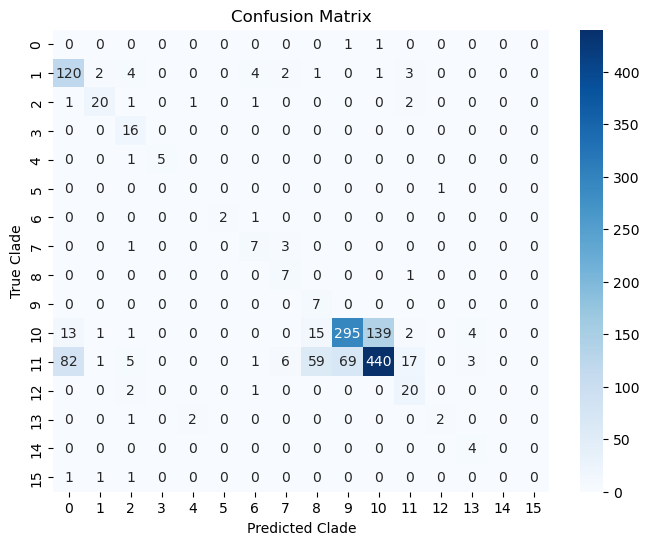

In [88]:

# Calculate and display metrics 
y_true_new = le_new.transform(new_df['Clade']) # Encode true labels

# Evaluate Predictions
print("\n### Model Evaluation on Test Dataset ###")

# Accuracy
accuracy = accuracy_score(y_true_new, y_pred_new)
print("Accuracy:", accuracy)

# Precision
precision = precision_score(y_true_new, y_pred_new, average='weighted') 
print("Precision:", precision)

# Recall
recall = recall_score(y_true_new, y_pred_new, average='weighted')
print("Recall:", recall)

# F1-score
f1 = f1_score(y_true_new, y_pred_new, average='weighted')
print("F1-score:", f1)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true_new, y_pred_new))

# Confusion Matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_true_new, y_pred_new)

plt.figure(figsize=(8, 6))
heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Clade")
plt.ylabel("True Clade")
plt.title("Confusion Matrix")
plt.show()
